# Qualitative Evaluation on self-trained embeddings

In [103]:
import argparse
import time
import math
import torch
import torch.nn as nn
from torch.autograd import Variable
from scipy.spatial.distance import cdist
import data
import model
import matplotlib.pyplot as plt
import pylab

In [2]:
corpus = data.Corpus('./data/brown')

In [4]:
#Load trained embeddings
model_trained = torch.load('model_winSize4_cpu.pt')
emb_trained = model_trained.encoder
emb_np = emb_trained.weight.data.numpy()

In [6]:
#TSNE Ploting
from sklearn.manifold import TSNE
TSNE_model = TSNE(n_components=2,random_state=0)

#Warning Long Training Process
representations2D = TSNE_model.fit_transform(emb_np)

In [105]:
# plt.figure(figsize=(10,10))
# plt.scatter(representations2D[:,0],representations2D[:,1],s=0.1)
# #for word_idx,word in enumerate(words_to_plot):
# #    plt.annotate(word,representations2D[word_idx])
# #plt.xlim([-100,100])
# #plt.ylim([-100,100])
# plt.title('2D representation: Brown 512d')
# plt.show()

In [106]:
from sklearn.cluster import KMeans
kmeans_brown = KMeans(init='k-means++', n_clusters=100, n_init=10)
kmeans_brown.fit(representations2D)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=100, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [107]:
def clusterPlot2D(rep2D,kmeans,savepath = 'TSNE_Plot',title='T-SNE representations'):
    plt.figure(figsize=(20,20))
    pylab.scatter(rep2D[:,0],rep2D[:,1],s=2,c=kmeans.labels_,cmap=pylab.cm.Accent)
    pylab.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],c='r')
    bbox_props = dict(boxstyle="rarrow", fc="cyan",pad=0.001, ec="b", lw=0.1)
    for center_idx,center in enumerate(kmeans.cluster_centers_):
        pylab.annotate(center_idx,center,bbox=bbox_props,rotation=45,va='top',ha='right')
    #for word_idx,word in enumerate(words_to_plot):
    #    plt.annotate(word,representations2D[word_idx])
    plt.title(title)
    plt.savefig('%s.png'%(savepath))
    plt.show()

def zoom(rep2D,kmeans,corpus,index_to_zoom,closest = 100):
    cluster_index = kmeans.labels_
    cluster_centers = kmeans.cluster_centers_
    plt.figure(figsize=(10,10))
    specified_pos = np.where(cluster_index==index_to_zoom)[0]
    rep2D_to_plot = rep2D[specified_pos]
    #calculate the distances between each word and its cluster center
    center = cluster_centers[index_to_zoom]
    dist2ctr = cdist(center.reshape(-1,2),rep2D_to_plot.reshape(-1,2),'euclidean')[0]
    #Sort by Euclidean Dist
    mat = np.zeros(len(dist2ctr)*4).reshape(len(dist2ctr),4)
    mat[:,:2] = rep2D_to_plot
    mat[:,2] = dist2ctr 
    mat[:,3] = specified_pos
    sorted_mat = np.array(sorted(mat,key=lambda x:x[2]))
    first_N_rep = sorted_mat[:closest,:2]
    first_N_idx = [int(x) for x in sorted_mat[:closest,3]]
    words_to_annotate = [corpus.dictionary.idx2word[idx] for idx in first_N_idx]
    #pylab.scatter(rep2D_to_plot[:,0],rep2D_to_plot[:,1],s=2)
    pylab.scatter(first_N_rep[:,0],first_N_rep[:,1],s=2)
    pylab.scatter(cluster_centers[index_to_zoom][0],cluster_centers[index_to_zoom][1],c='r')
    for word_pos,coordinate in enumerate(first_N_rep):
        pylab.annotate(words_to_annotate[word_pos],coordinate)
    plt.show()
    return words_to_annotate
    

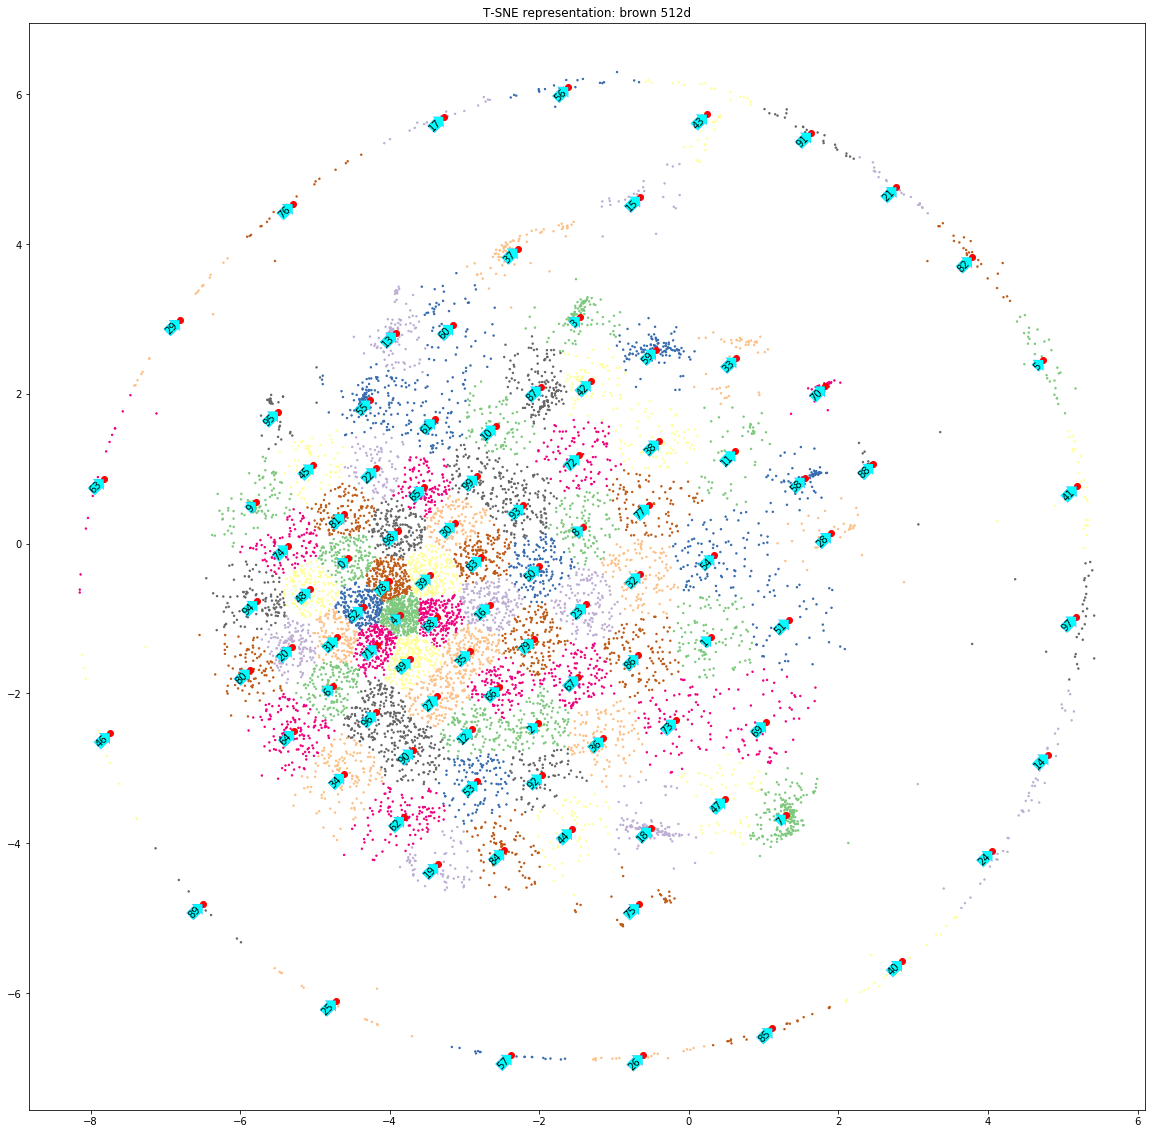

In [108]:
clusterPlot2D(representations2D,kmeans_brown\
              ,savepath='tsne.png',title='T-SNE representation: brown 512d')

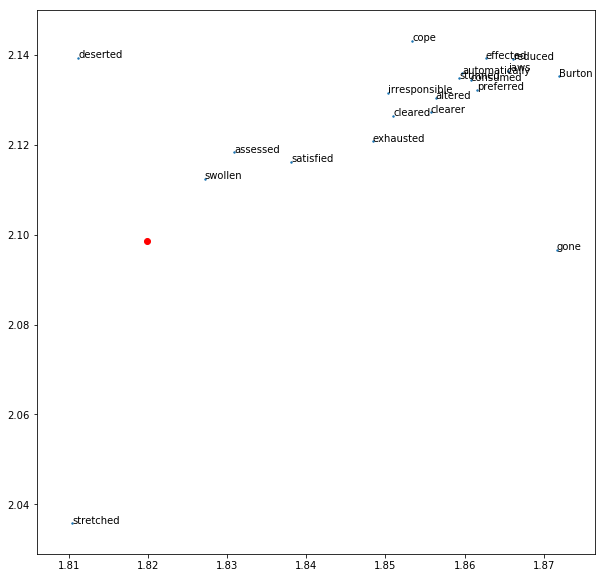

['swollen', 'assessed', 'satisfied', 'exhausted', 'deserted', 'cleared', 'irresponsible', 'clearer', 'altered', 'gone', 'stunned', 'preferred', 'consumed', 'automatically', 'cope', 'effected', 'jaws', 'reduced', 'stretched', 'Burton']


In [111]:
print(zoom(representations2D,kmeans_brown,corpus,index_to_zoom=70,closest=20))

# Hold-out prediction sample

In [9]:
from nltk.corpus import semcor

In [25]:
example_sent = semcor.sents()[100]

In [26]:
' '.join(example_sent)

"`` If you destroy confidence in banks , you do something to the economy '' , he said ."

In [56]:
context_eg = example_sent[6-4:6+4+1]
holdout = context_eg[4]
print('Context: %s'%(' '.join(context_eg)))
print('Holdout word: %s'%(holdout))

Context: you destroy confidence in banks , you do something
Holdout word: banks


In [84]:
context_idx = Variable(torch.LongTensor([corpus.dictionary.word2idx[word] for word in context_eg]).view(-1,1))
#context_idx[4] = 0

In [89]:
hidden = model_trained.init_hidden(1)

output,hidden = model_trained.forward(context_idx,hidden)

output_np = output.data.numpy()

best10 = sorted(output_np[0],reverse=True)[9]

In [90]:
best10

7.089817

In [91]:
import numpy as np
predictions = np.where(output_np>=best10)[1]

In [92]:
[corpus.dictionary.idx2word[idx] for idx in predictions]

['fact',
 'himself',
 'you',
 'learning',
 'say',
 'change',
 'cars',
 'instance',
 'herself',
 'imagine']

The Prediction base on context window of size 4 seems merely recognize the pos (Noun)